# Import Libraries
Doc for importing posts from public facebook page: https://github.com/kevinzg/facebook-scraper

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from collections.abc import Iterable
from facebook_scraper import get_posts 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
import spacy
from spacy.matcher import PhraseMatcher
import statsmodels.api as sm

# Scrape posts and comments from Facebook

* Set **'comments' = True or a number (limit)** to scrape post comments
* Increase pages to capture more posts

In [4]:
listposts = []

for post in get_posts('TransportForNSW', 
                      pages=3,
                      options={'comments': True}):
    listposts.append(post)
    
print('Number of posts: {}'.format(len(listposts)))    

Number of posts: 198


# Data Processing

* Copy Raw Facebook posts data into dataframe
* Select only columns to be used for text analysis

In [5]:
columns = ['post_id', 
           'time',  
           'text', 
           'likes',
           'comments', 
           'shares', 
           'comments_full']

df_posts = pd.DataFrame(listposts)[columns]

* Create new data frame for all FB comments
* Add sentiment scores from VADER library

In [6]:
analyzer = SentimentIntensityAnalyzer()

list_comments = []
for index, row in df_posts.iterrows():
    post_id = row['post_id']
    if isinstance(row['comments_full'], Iterable):
        for comment in row['comments_full']:
            dict_temp = {}
            dict_temp['post_id'] = post_id
            dict_temp['comment'] = comment['comment_text']
            dict_temp['sentiment'] = analyzer.polarity_scores(
                comment['comment_text'])['compound']
            list_comments.append(dict_temp)        

df_comments = pd.DataFrame(list_comments)

* Calculate mean comments' sentiment scores for each posts
* Add post sentiment data to data frame
* Save all data to Excel file - for later use

In [7]:
posts_sentiment = df_comments.groupby('post_id').mean()

df_posts = df_posts.join(posts_sentiment, on=['post_id'])

df_posts.drop(columns=['comments_full'], inplace=True)
df_posts.fillna(0.0, inplace=True)

with pd.ExcelWriter('data/TfNSW_FB_new.xlsx') as writer:
    df_posts.to_excel(writer, sheet_name='posts_data', index_label='ID')
    df_comments.to_excel(writer, sheet_name='posts_comments', index_label='ID')
    

In [3]:
# Load data from exisiting files to save time
df_posts = pd.read_excel('data/TfNSW_FB.xlsx', sheet_name='posts_data')
df_comments = pd.read_excel('data/TfNSW_FB.xlsx', sheet_name='posts_comments')

In [94]:
# print out dataframe for posts 
df_posts.head()

,ID,post_id,time,text,likes,comments,shares,sentiment
0,0,1924048097753160,2021-05-31 16:00:46,We’ve hit a Sydney Metro - NSW GOV milestone: ...,11,1,0,0.000000
1,1,1921019011389402,2021-05-27 12:20:00,Construction safety standards have certainly i...,35,7,0,-0.137383
2,2,1920457328112237,2021-05-27 08:30:00,We’re proud to support National Reconciliation...,17,0,0,0.000000
3,3,1920274138130556,2021-05-26 12:14:56,You can now access Street View imagery of the ...,17,0,0,0.000000
4,4,1918717961619507,2021-05-24 12:30:09,✅ Parramatta ↔️ CBD: 20 minutes\n✅ Blacktown ↔...,49,4,0,0.000000


In [93]:
# print out dataframe for comments 
df_comments.head()

,ID,post_id,comment,sentiment
0,0,1921019011389402,If that stone broke and fell on the guy with t...,-0.4753
1,1,1921019011389402,PPE doesnt stop or prevent accidents.,-0.1245
2,2,1921019011389402,"Yet, somehow we survived.",0.5106
3,3,1921019011389402,But incompetence and corruption hasn't worse m...,-0.3423
4,4,1921019011389402,Shocking!!!!,-0.5951


# Texts Summary - Word Cloud analysis

* Generate word cloud for all post texts

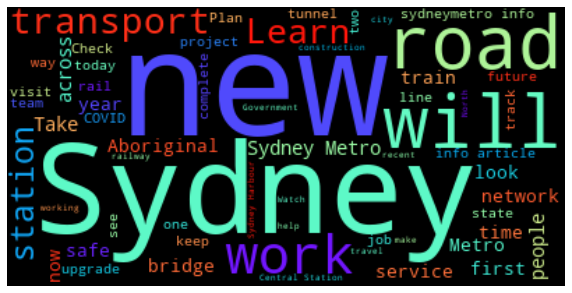

In [6]:
# merge all texts in posts
post_text = ' '.join(df_posts['text'])
post_text = post_text.replace('\n', '') # remove blank lines characters

# update stopwords
stopwords = set(STOPWORDS)
stopwords.update(['https', 'gov', 'au', 'nsw', 's', 're'])

# Generate a word cloud image
wordcloud = WordCloud(random_state=1, 
                      collocations=True, 
                      stopwords=stopwords,
                      max_words=60,
                      background_color='black',
                      colormap ='rainbow',
                      contour_color='steelblue').generate(post_text)

# Function to display word cloud img via matplotlib
def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

# plot world cloud    
plot_cloud(wordcloud)

# Text Analysis - Popularity of Products / Services
* Which TfNSw services / products are liked the most and the least?

In [7]:
# list of common products / services
products = ['train', 'bus', 'ferry', 'light rail', 'metro', 
            'road', 'bridge', 'westconnex', 'walk', 'cycling']

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Create the PhraseMatcher object. The tokenizer is the first argument. Use attr = 'LOWER' to make consistent capitalization
matcher = PhraseMatcher(nlp.vocab, attr='LOWER')

# Only run nlp.make_doc to speed things up
prod_tokens = [nlp.make_doc(text) for text in products]

# Add the item patterns to the matcher
matcher.add("TfNSWProducts", prod_tokens)

## Sentiment scores and likes - based on content from FB Posts 

In [8]:
# Use defaultdict to create dictionary of sentiment scores by product
# If a key doesn't exist in item_ratings, the key is added with an empty list as the value.
product_sentiment = defaultdict(list)
product_likes = defaultdict(list)

# add sentiment scores from posts to each product
for idx, post in df_posts.iterrows():
    doc = nlp(post.loc['text'])
    
    # Using the matcher created before
    matches = matcher(doc)
    
    # Create a set of the items found in the review text
    found_products = set()
    for match_id, start, end in matches:
        product = doc[start:end].text.lower() # remove case sensitives
        found_products.add(product)
    
    # add sentiment scores to each products found in post
    for product in found_products:
        product_sentiment[product].append(post.sentiment)
        product_likes[product].append(post.likes)

<AxesSubplot:ylabel='Sentiment score'>

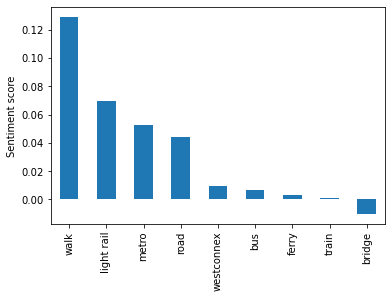

In [67]:
# Calculate the mean sentiment score for each product
mean_sentiment = {}

for product, score in product_sentiment.items():
    avg_score = sum(score) / len(score)
    mean_sentiment[product] = avg_score

# create dataframe for sentiment scores by product    
df_prod_sentiment = pd.DataFrame(mean_sentiment, index=['sentiment']).transpose()
df_prod_sentiment = df_prod_sentiment.sort_values(by=['sentiment'], ascending=False)

# plot sentiment score by products
df_prod_sentiment.plot(kind='bar', legend=False, ylabel='Sentiment score')

* On average, posts related to 'walk' has the highest sentiment score at 0.12 (slightly possitive). Followed by 'Light rail' and 'Metro'.

<AxesSubplot:ylabel='Number of Likes'>

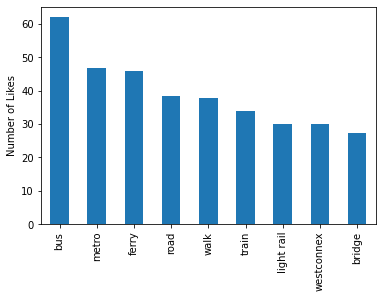

In [9]:
# Calculate the avg number of likes  for each product
mean_likes = {}

for product, likes in product_likes.items():
    avg_likes = sum(likes) / len(likes)
    mean_likes[product] = avg_likes

# create dataframe for sentiment scores by product    
df_prod_likes = pd.DataFrame(mean_likes, index=['likes']).transpose()
df_prod_likes = df_prod_likes.sort_values(by=['likes'], ascending=False)

# plot sentiment score by products
df_prod_likes.plot(kind='bar', legend=False, ylabel='Number of Likes')

* On average, posts related to 'bus' have highest number of likes (~60). Followed by 'Metro' and 'Ferry'.
* Coincidentally, these modes typically have highest Customer Satisfaction ratings - per publication from TfNSW's annual surveys.

## Statistical model for Transport for NSW FB Post's Sentiment

* Using OLS model to identify which characteristics of FB Posts are good predictors for sentiment scores (for Transport NSW  public page)
* I decided to use parametric model for explainability. OLS is chosen for quick computational time.

In [90]:
df_posts_new = df_posts # create a new df to incorporate new features

# create df for product term counts by FB posts
df_product_terms = pd.DataFrame(columns=products, index=df_posts_new.index)
df_product_terms.fillna(0, inplace=True) # remove NA in order to add increments

# count product term matches for each posts
for idx, post in df_posts_new.iterrows():
    doc = nlp(post.loc['text'])
    
    # Using the matcher created before
    matches = matcher(doc)
    
    # Create a set of the items found in the review text
    for match_id, start, end in matches:
        product = doc[start:end].text.lower() # remove case sensitives
        df_product_terms.loc[idx, product] += 1

* The below code shows routine for OLS model fit using statsmodels.api
* Based on p-values, **number of likes and comments** are strong predictors of sentiment scores, as well as number of mentions for the following modes: **light rail, road, bridge, walk**.

In [92]:
# add product term counts to df
df_posts_new = df_posts_new.join(df_product_terms)

# predictors and target variable
features = ['likes', 'comments', 'shares'] + products
X = df_posts_new[features]
y = df_posts_new['sentiment']

# fit OLS model using statmodels api
X = sm.add_constant(X, prepend=False) # add constant term
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     3.974
Date:                Tue, 01 Jun 2021   Prob (F-statistic):           1.83e-05
Time:                        21:32:52   Log-Likelihood:                 131.52
No. Observations:                 198   AIC:                            -237.0
Df Residuals:                     185   BIC:                            -194.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
likes          0.0005      0.000      2.669      0.0

C:\Anaconda3\envs\anh_dev\lib\site-packages\statsmodels\regression\linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
